# Trabalho 02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import sys
import os 
sys.path.insert(0, os.path.abspath('../packages'))
import steps, functions, optimizers, constraints, constropt

In [3]:
step = steps.GoldenSectionStep(da = 0.01, tol = 1e-8, check_direction=True, normalize=True)

In [4]:
tol_osr = 1e-7
optimizrs = [
    ('Univariant', optimizers.UnivariantOptimizer(tol=tol_osr)),
    ('Powell', optimizers.PowellOptimizer(tol=tol_osr)),
    ('Steepest', optimizers.SteepestDescentOptimizer(tol=tol_osr)),
    ('FletchRvs', optimizers.FletcherReevesOptimizer(tol=tol_osr)),
    ('NewtnRaph', optimizers.NewtonRaphsonOptimizer(tol=tol_osr)),
    ('BFGS', optimizers.BFGSOptimizer(tol=tol_osr)),
]

In [5]:
constrained_optimizer = constropt.ConstrainedOptimizer(tol=1e-6)

## Questão 01

### Função a minimizar

In [6]:
def f(x1, x2):

    return (x1 - 2)**4 + (x1-2*x2)**2

def gradf(x1, x2):

    return np.array(
        [ 4.0*(x1 - 2.0)**3.0 + 2.0*(x1-2.0*x2), 
        -4.0*(x1-2.0*x2)]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 12.0*(x1-x2)**2 + 2.0, -4.0],
        [-4.0,  8.0]
        ]
    )

f = functions.AnalyticalSpecialFunction(f, gradf, hessf)


### Restrição

In [7]:
cfs = []

def cf(x1, x2):

    return x1**2 - x2

def gradf(x1, x2):

    return np.array(
        [ 2.0*x1, 
        -1.0]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 2.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

In [8]:
cases = [
    ('Penalidade', np.array([3,2]), [constraints.PenaltyInequityConstraint(cf, r0=1.0, beta=10.0) for cf in cfs], 'r'),
    ('Barreira'  , np.array([0,1]), [constraints.BarrierInequityConstraint(cf, r0=10.0, beta=0.1) for cf in cfs], 'b')
]

Univariant (Penalidade): p_final = [0.942897, 0.889055, 1.946311].T. Execução:0:00:00.653645, 8 iterações
Univariant (Barreira): p_final = [0.947491, 0.897738, 1.946248].T. Execução:0:00:02.946536, 13 iterações
Powell (Penalidade): p_final = [0.945580, 0.894121, 1.946183].T. Execução:0:00:00.441917, 8 iterações
Powell (Barreira): p_final = [1.998103, 0.999051, 0.000000].T. Execução:0:00:10.097599, 13 iterações
Steepest (Penalidade): p_final = [0.945543, 0.894051, 1.946183].T. Execução:0:00:00.650081, 8 iterações
Steepest (Barreira): p_final = [1.941024, 0.970586, 0.000012].T. Execução:0:00:13.262647, 13 iterações
FletchRvs (Penalidade): p_final = [0.945584, 0.894129, 1.946183].T. Execução:0:00:00.592902, 8 iterações
FletchRvs (Barreira): p_final = [1.992697, 0.996350, 0.000000].T. Execução:0:00:12.761525, 13 iterações
NewtnRaph (Penalidade): p_final = [0.945583, 0.894127, 1.946183].T. Execução:0:00:00.465980, 8 iterações
NewtnRaph (Barreira): p_final = [2.012888, 1.006444, 0.000000].T.

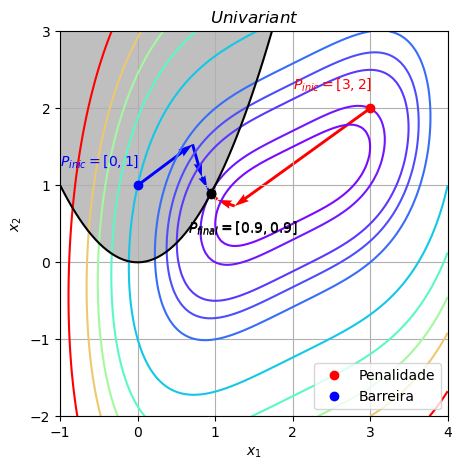

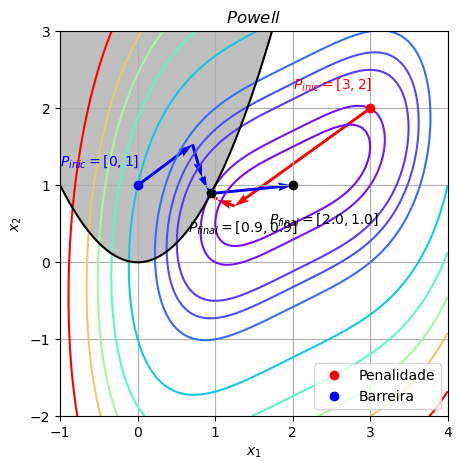

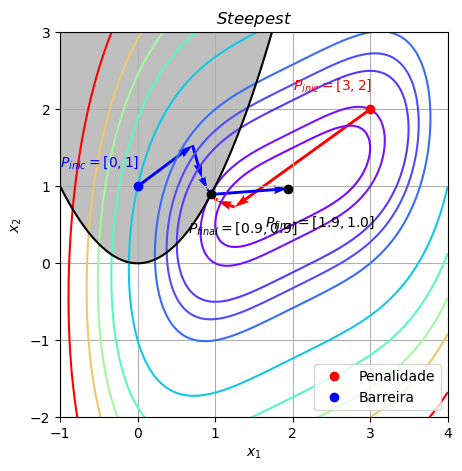

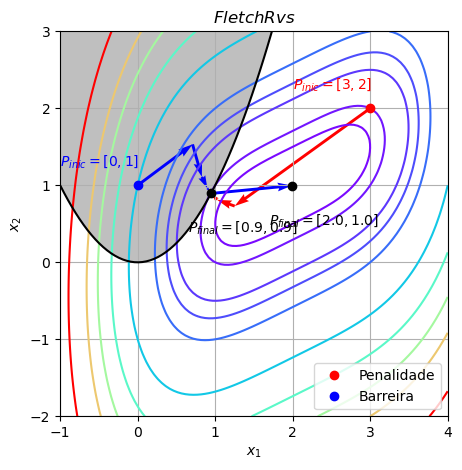

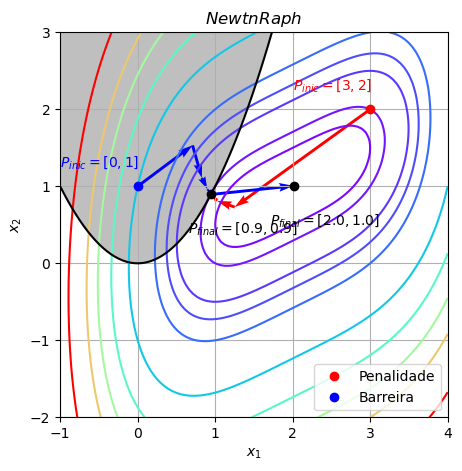

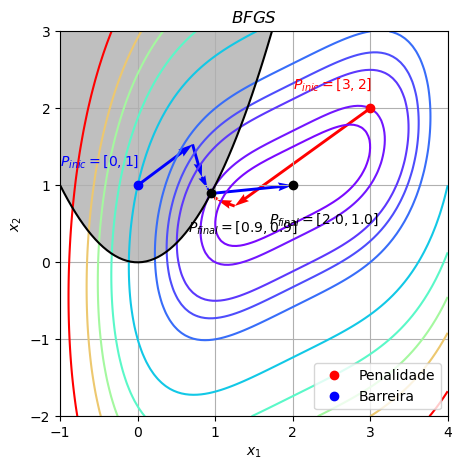

In [9]:
item = '1'

x = np.linspace(-1, 4, 100)
y = np.linspace(-2, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
levels =[0, 1, 2, 5, 7, 10, 20, 30, 40, 50, 70]
#levels = np.linspace(0,120, 10)
cZs = [cf(X, Y) for cf in cfs]

for name, optimizer in optimizrs:
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.contour(X, Y, Z, levels ,cmap='rainbow')
    for cZ in cZs:
        ax.contour(X, Y, cZ, [0],cmap='gray')
        ax.contourf(X, Y, cZ, [-100000, 0],cmap='gray', alpha=0.5)
    for case_name, p_inicial, constrs, color in cases:
        t_init = datetime.datetime.now()
        f_otim = constraints.ConstrainedSpecialFunction(f, cfuncs=constrs)
        p_final = constrained_optimizer(f_otim, p_inicial, optimizer, step)
        t_final = datetime.datetime.now()
        print(f'{name} ({case_name}): p_final = [{p_final[0]:.6f}, {p_final[1]:.6f}, {f(*p_final):.6f}].T. Execução:{t_final - t_init}, {constrained_optimizer.iter} iterações')
        ax.plot(*p_inicial, f'{color}o',label=case_name)
        ax.text(p_inicial[0]-1.0, p_inicial[1]+0.25, f'$P_{{inic}} = [{p_inicial[0]}, {p_inicial[1]}]$', color=color)
        ax.plot(*p_final, 'ko')
        ax.text(p_final[0]-0.3, p_final[1]-0.5, f'$P_{{final}} = [{p_final[0]:.1f}, {p_final[1]:.1f}]$', color='k')
        cache = constrained_optimizer.cache_x
        for i in range(len(cache)-1):
            p_i = cache[i]
            p_f = cache[i+1]
            ax.quiver(p_i[0], p_i[1], p_f[0]-p_i[0], p_f[1]-p_i[1], color=color, angles='xy', scale_units='xy', scale=1)#, label='Passo completo')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'${name}$')
    fig.savefig(f'images/q{item}_{name}.pdf')

## Questão 02

### Parâmetros

In [6]:
rho = 0.3
B = 30.0
P = 33.0e3
t = 0.1
E = 3.0e7
sigma_y = 1.0e5

### Função a minimizar

In [7]:
def f(d, H):

    return 2.0*rho*np.pi*d*t*np.sqrt(H**2 + B**2)

def gradf(d, H):

    return np.array([2.0*np.pi*rho*t*np.sqrt(B**2 + H**2), 2.0*H*d*np.pi*rho*t/np.sqrt(B**2 + H**2)])

def hessf(d, H):

    return np.array([[0, 2.0*H*np.pi*rho*t/np.sqrt(B**2 + H**2)], [2.0*H*np.pi*rho*t/np.sqrt(B**2 + H**2), -2.0*H**2*d*np.pi*rho*t/(B**2 + H**2)**(3/2) + 2.0*d*np.pi*rho*t/np.sqrt(B**2 + H**2)]])

f = functions.AnalyticalSpecialFunction(f, gradf, hessf)

### Restrições

In [8]:
cfs = []

def cf(d, H):

    return P * np.sqrt(H**2 + B**2) / (np.pi * d * t * H) - sigma_y

def gradf(d, H):

    return np.array([-P*np.sqrt(B**2 + H**2)/(H*d**2*np.pi*t), P/(d*np.pi*t*np.sqrt(B**2 + H**2)) - P*np.sqrt(B**2 + H**2)/(H**2*d*np.pi*t)])

def hessf(d, H):

    return np.array([[2*P*np.sqrt(B**2 + H**2)/(H*d**3*np.pi*t), -P/(d**2*np.pi*t*np.sqrt(B**2 + H**2)) + P*np.sqrt(B**2 + H**2)/(H**2*d**2*np.pi*t)], [-P/(d**2*np.pi*t*np.sqrt(B**2 + H**2)) + P*np.sqrt(B**2 + H**2)/(H**2*d**2*np.pi*t), -H*P/(d*np.pi*t*(B**2 + H**2)**(3/2)) - P/(H*d*np.pi*t*np.sqrt(B**2 + H**2)) + 2*P*np.sqrt(B**2 + H**2)/(H**3*d*np.pi*t)]])

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

def cf(d, H):

    return P * np.sqrt(H**2 + B**2) / (np.pi * d * t * H) - np.pi **2 * E * (d**2+t**2) / (8.0*(H**2 + B**2))

def gradf(d, H):

    return np.array([-2*E*d*np.pi**2/(8.0*B**2 + 8.0*H**2) - P*np.sqrt(B**2 + H**2)/(H*d**2*np.pi*t), 0.25*E*H*np.pi**2*(d**2 + t**2)/(B**2 + H**2)**2 + P/(d*np.pi*t*np.sqrt(B**2 + H**2)) - P*np.sqrt(B**2 + H**2)/(H**2*d*np.pi*t)])

def hessf(d, H):

    return np.array([[-2*E*np.pi**2/(8.0*B**2 + 8.0*H**2) + 2*P*np.sqrt(B**2 + H**2)/(H*d**3*np.pi*t), 0.5*E*H*d*np.pi**2/(B**2 + H**2)**2 - P/(d**2*np.pi*t*np.sqrt(B**2 + H**2)) + P*np.sqrt(B**2 + H**2)/(H**2*d**2*np.pi*t)], [0.5*E*H*d*np.pi**2/(B**2 + H**2)**2 - P/(d**2*np.pi*t*np.sqrt(B**2 + H**2)) + P*np.sqrt(B**2 + H**2)/(H**2*d**2*np.pi*t), -1.0*E*H**2*np.pi**2*(d**2 + t**2)/(B**2 + H**2)**3 + 0.25*E*np.pi**2*(d**2 + t**2)/(B**2 + H**2)**2 - H*P/(d*np.pi*t*(B**2 + H**2)**(3/2)) - P/(H*d*np.pi*t*np.sqrt(B**2 + H**2)) + 2*P*np.sqrt(B**2 + H**2)/(H**3*d*np.pi*t)]])

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)


In [13]:
cases = [
    ('Penalidade', np.array([1, 15]), 
     [constraints.PenaltyInequityConstraint(cf, r0=1e-7, beta=10.0) for cf in cfs], 'r',
     steps.GoldenSectionStep(da = 0.01, tol = 1e-8, check_direction=True, normalize=True, verbose=False)),
    ('Barreira'  , np.array([4,25]), 
     [constraints.BarrierInequityConstraint(cf, r0=1e7, beta=0.1) for cf in cfs], 'b',
     steps.GoldenSectionStep(da = 0.01, tol = 1e-8, check_direction=True, normalize=True, verbose=False, treshold=1e-6))
]

constrained_optimizer = constropt.ConstrainedOptimizer(tol=1.1e-6, verbose=True, max_iter=50)

Iniciando Univariant (Penalidade): p_inicial = [1.000000, 15.000000].T
    Beginning iteration: 1
    Ending iteration: 1. Final point: 1.8771287594164563,20.09695347179265, loss: 0.01779104439479706
    Beginning iteration: 2
    Ending iteration: 2. Final point: 1.878233754426684,20.222366689494795, loss: 0.0018557872533640778
    Beginning iteration: 3
    Ending iteration: 3. Final point: 1.8783442932843262,20.235448229869707, loss: 0.0001863836997251032
    Beginning iteration: 4
    Ending iteration: 4. Final point: 1.8783553472670211,20.236762074503662, loss: 1.8639678246646457e-05
    Beginning iteration: 5
    Ending iteration: 5. Final point: 1.8783564524714287,20.236893515267937, loss: 1.8587526473972014e-06
    Beginning iteration: 6
    Ending iteration: 6. Final point: 1.8783565634765242,20.23690665633616, loss: 1.788118511220115e-07
Univariant (Penalidade): p_final = [1.878357, 20.236907, 12.812600].T. Execução:0:00:01.241029, 6 iterações
Iniciando Powell (Penalidade): p

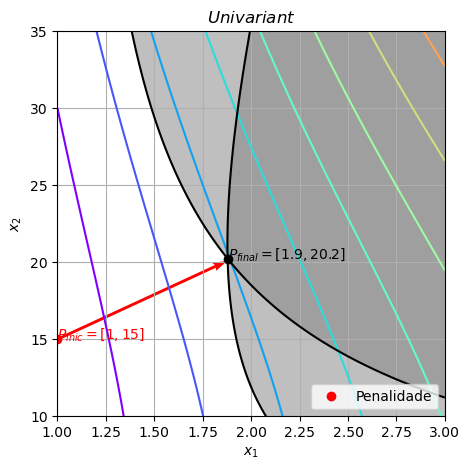

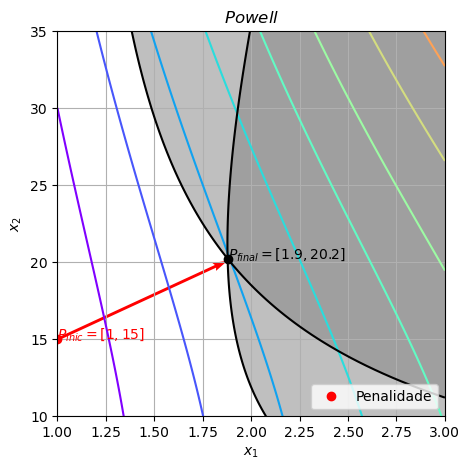

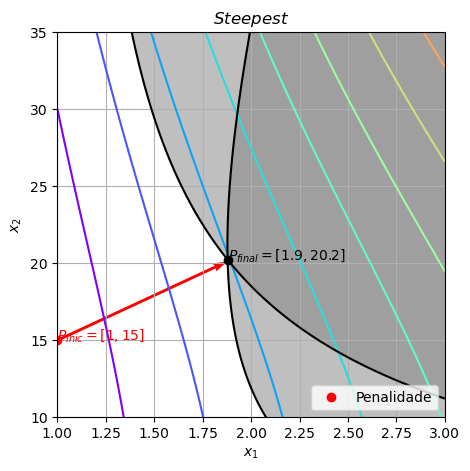

In [15]:
item = '2'

x = np.linspace(1, 3, 100)
y = np.linspace(10, 35, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
#levels =[0, 1, 2, 5, 7, 10, 20, 30, 40, 50, 70]
levels = np.linspace(8,30, 10)
cZs = [cf(X, Y) for cf in cfs]

for name, optimizer in optimizrs:
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.contour(X, Y, Z, levels ,cmap='rainbow')
    for cZ in cZs:
        ax.contour(X, Y, cZ, [0],cmap='gray')
        ax.contourf(X, Y, cZ, [-1000000000, 0],cmap='gray', alpha=0.5)
    for case_name, p_inicial, constrs, color, step in cases:
        if case_name == 'Barreira' and name not in ['NewtnRaph']: break
        print(f'Iniciando {name} ({case_name}): p_inicial = [{p_inicial[0]:.6f}, {p_inicial[1]:.6f}].T')
        t_init = datetime.datetime.now()
        f_otim = constraints.ConstrainedSpecialFunction(f, cfuncs=constrs)
        p_final = constrained_optimizer(f_otim, p_inicial, optimizer, step)
        t_final = datetime.datetime.now()
        print(f'{name} ({case_name}): p_final = [{p_final[0]:.6f}, {p_final[1]:.6f}, {f(*p_final):.6f}].T. Execução:{t_final - t_init}, {constrained_optimizer.iter} iterações')
        ax.plot(*p_inicial, f'{color}o',label=case_name)
        ax.text(p_inicial[0]-0.0, p_inicial[1]+0.025, f'$P_{{inic}} = [{p_inicial[0]}, {p_inicial[1]}]$', color=color)
        ax.plot(*p_final, 'ko')
        ax.text(p_final[0]-0.0, p_final[1]+0.025, f'$P_{{final}} = [{p_final[0]:.1f}, {p_final[1]:.1f}]$', color='k')
        cache = constrained_optimizer.cache_x
        for i in range(len(cache)-1):
            p_i = cache[i]
            p_f = cache[i+1]
            ax.quiver(p_i[0], p_i[1], p_f[0]-p_i[0], p_f[1]-p_i[1], color=color, angles='xy', scale_units='xy', scale=1)#, label='Passo completo')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'${name}$')
    fig.savefig(f'images/q{item}_{name}.pdf')

## Questão 03

### Função a minimizar

In [10]:
def f(x1, x2):

    return (x1 - 10)**3 + (x2 - 20)**3

def gradf(x1, x2):

    return np.array(
        [ 3.0*(x1 - 10) ** 2, 
          3.0*(x2 - 20) ** 2]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 6.0*(x1 - 10), 0.0],
        [ 0.0,  6.0*(x1 - 20)]
        ]
    )

f = functions.AnalyticalSpecialFunction(f, gradf, hessf)
#f = functions.NumericalSpecialFunction(f)


### Restrições

In [11]:
cfs = []

# 100.0 - (x1 - 5.0)**2 - (x2 - 5.0)**2 <= 0
def cf(x1, x2):

    return 100.0 - (x1 - 5.0)**2 - (x2 - 5.0)**2

def gradf(x1, x2):

    return np.array(
        [ -2.0*(x1 - 5), 
          -2.0*(x2 - 5)]
    )

def hessf(x1, x2):

    return np.array(
        [
        [-2.0, 0.0],
        [ 0.0,-2.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
#cf = functions.NumericalSpecialFunction(cf)
cfs.append(cf)

# -82.81 + (x1 - 6.0)**2 + (x2 - 5.0)**2 <= 0
def cf(x1, x2):

    return -82.81 + (x1 - 6.0)**2 + (x2 - 5.0)**2

def gradf(x1, x2):

    return np.array(
        [ 2.0*(x1 - 6), 
          2.0*(x2 - 5)]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 2.0, 0.0],
        [ 0.0, 2.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
#cf = functions.NumericalSpecialFunction(cf)
cfs.append(cf)

'''
# x1 - 100 <= 0
def cf(x1, x2):

    return x1 - 100.0

def gradf(x1, x2):

    return np.array(
        [  1.0, 
           0.0]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 0.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)
'''
'''
# 13.0 - x1 <= 0
def cf(x1, x2):

    return 13.0 - x1

def gradf(x1, x2):

    return np.array(
        [ -1.0, 
           0.0]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 0.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

#cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cf = functions.NumericalSpecialFunction(cf)
cfs.append(cf)
'''

'''
# x2 - 100 <= 0
def cf(x1, x2):

    return x2 - 100.0

def gradf(x1, x2):

    return np.array(
        [  0.0, 
           1.0]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 0.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)
'''

'''
# -x2 <= 0
def cf(x1, x2):

    return -x2

def gradf(x1, x2):

    return np.array(
        [  0.0, 
          -1.0]
    )

def hessf(x1, x2):

    return np.array(
        [
        [ 0.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

#cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cf = functions.NumericalSpecialFunction(cf)
cfs.append(cf)
'''

dummy = None

In [12]:
cases = [
    ('Penalidade', np.array([14, 6]), 
     [constraints.PenaltyInequityConstraint(cf, r0=1.0, beta=10.0) for cf in cfs], 'r',
     steps.GoldenSectionStep(da = 0.01, tol = 1e-8, check_direction=True, normalize=True, verbose=False)),
    ('Barreira'  , np.array([15.05,4.8]), 
     [constraints.BarrierInequityConstraint(cf, r0=1e40, beta=0.1) for cf in cfs], 'b',
     steps.GoldenSectionStep(da = 0.01, tol = 1e-8, check_direction=True, normalize=False, verbose=False))
]

constrained_optimizer = constropt.ConstrainedOptimizer(tol=1e-6, verbose=False, max_iter=50)

Iniciando Univariant (Penalidade): p_inicial = [14.000000, 6.000000].T
Univariant (Penalidade): p_final = [14.094999, 0.842959, -6961.816112].T. Execução:0:00:07.463043, 50 iterações
Iniciando Powell (Penalidade): p_inicial = [14.000000, 6.000000].T
Powell (Penalidade): p_final = [14.095000, 0.842961, -6961.813825].T. Execução:0:00:03.485373, 12 iterações
Iniciando Steepest (Penalidade): p_inicial = [14.000000, 6.000000].T
Steepest (Penalidade): p_final = [14.095026, 0.843012, -6961.755842].T. Execução:0:00:06.585165, 43 iterações
Iniciando FletchRvs (Penalidade): p_inicial = [14.000000, 6.000000].T
FletchRvs (Penalidade): p_final = [14.095001, 0.842963, -6961.811505].T. Execução:0:00:02.374800, 14 iterações
Iniciando NewtnRaph (Penalidade): p_inicial = [14.000000, 6.000000].T
NewtnRaph (Penalidade): p_final = [14.095000, 0.842961, -6961.813871].T. Execução:0:00:07.769404, 50 iterações
Iniciando NewtnRaph (Barreira): p_inicial = [15.050000, 4.800000].T
NewtnRaph (Barreira): p_final = [

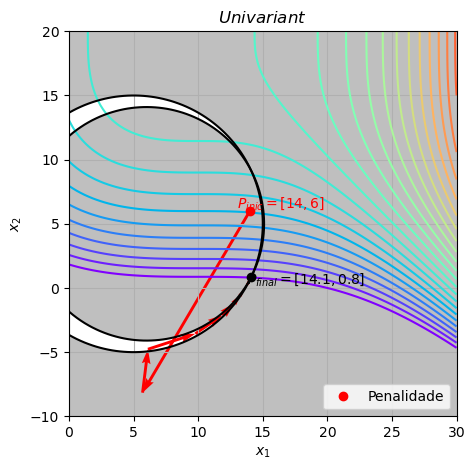

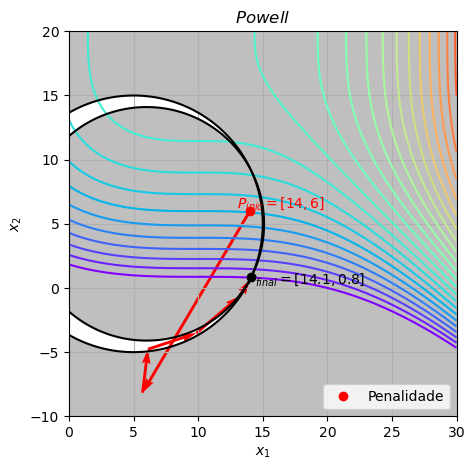

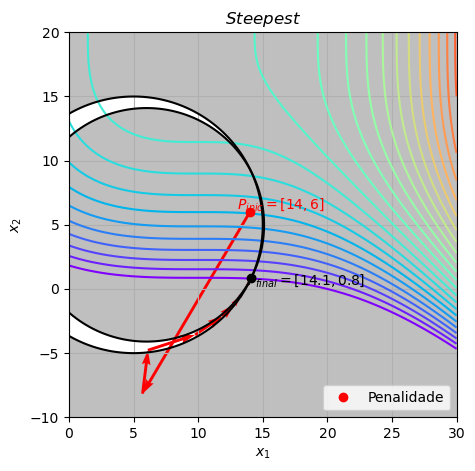

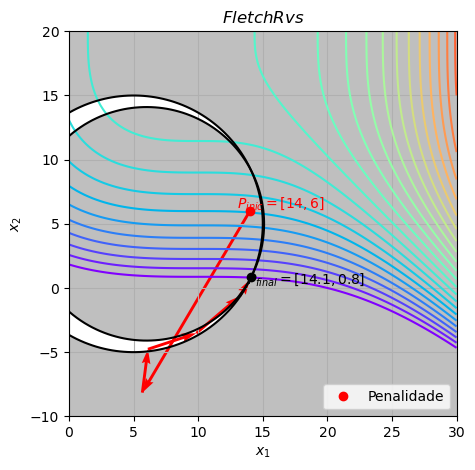

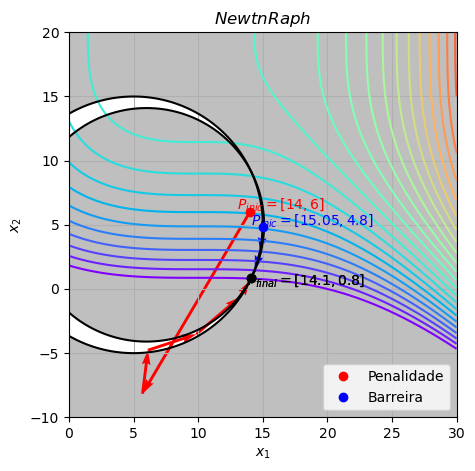

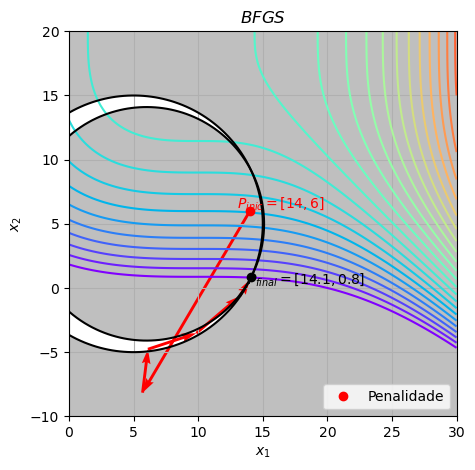

In [13]:
item = '3'

x = np.linspace(0, 30, 100)
y = np.linspace(-10, 20, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
#levels =[0, 1, 2, 5, 7, 10, 20, 30, 40, 50, 70]
levels = np.linspace(-7000,10000, 25)
cZs = [cf(X, Y) for cf in cfs]

for name, optimizer in optimizrs:
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.contour(X, Y, Z, levels ,cmap='rainbow')
    for cZ in cZs:
        ax.contour(X, Y, cZ, [0],cmap='gray')
        ax.contourf(X, Y, cZ, [-100000, 0],cmap='gray', alpha=0.5)
    for case_name, p_inicial, constrs, color, step in cases:
        if case_name == 'Barreira' and name not in ['NewtnRaph']: break
        print(f'Iniciando {name} ({case_name}): p_inicial = [{p_inicial[0]:.6f}, {p_inicial[1]:.6f}].T')
        t_init = datetime.datetime.now()
        f_otim = constraints.ConstrainedSpecialFunction(f, cfuncs=constrs)
        p_final = constrained_optimizer(f_otim, p_inicial, optimizer, step)
        t_final = datetime.datetime.now()
        print(f'{name} ({case_name}): p_final = [{p_final[0]:.6f}, {p_final[1]:.6f}, {f(*p_final):.6f}].T. Execução:{t_final - t_init}, {constrained_optimizer.iter} iterações')
        ax.plot(*p_inicial, f'{color}o',label=case_name)
        ax.text(p_inicial[0]-1.0, p_inicial[1]+0.25, f'$P_{{inic}} = [{p_inicial[0]}, {p_inicial[1]}]$', color=color)
        ax.plot(*p_final, 'ko')
        ax.text(p_final[0]-0.3, p_final[1]-0.5, f'$P_{{final}} = [{p_final[0]:.1f}, {p_final[1]:.1f}]$', color='k')
        cache = constrained_optimizer.cache_x
        for i in range(len(cache)-1):
            p_i = cache[i]
            p_f = cache[i+1]
            ax.quiver(p_i[0], p_i[1], p_f[0]-p_i[0], p_f[1]-p_i[1], color=color, angles='xy', scale_units='xy', scale=1)#, label='Passo completo')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'${name}$')
    fig.savefig(f'images/q{item}_{name}.pdf')

## Questão 04

### Parâmetros

In [6]:
P = 100000.0 # N
L = 5.0 # m
E = 210e9 # Pa
sigma_a = 250e6 # Pa
DELTA = 0.25 # m
rho = 7850.0 # kg/m

### Função a minimizar

In [7]:
def f(R, t):

    return 2.0*np.pi*R*t*L*rho

def gradf(R, t):

    return np.array(
        [ 2.0*np.pi*t*L*rho, 
          2.0*np.pi*R*L*rho]
    )

def hessf(R, t):

    return np.array(
        [
        [ 0.0, 2.0*np.pi*L*rho],
        [ 2.0*np.pi*L*rho, 0.0]
        ]
    )

f = functions.AnalyticalSpecialFunction(f, gradf, hessf)

### Restrições

In [8]:
cfs = []

# sigma <= sigma_a
def cf(R, t):
    e = 0.02 * R
    c = R + 0.5*t
    A = 2*np.pi*R*t
    I = np.pi* R**3 *t
    k2 = I/A
    sigma = P/A * (1.0 + e*c/k2 * (1.0/np.cos(L*np.sqrt(np.abs(P/(E*I))))))
    return sigma - sigma_a

def gradf(R, t):

    return np.array([(1/2)*P*(-0.06*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.04/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.04*(R + 0.5*t)/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t) - 1/2*P*(1.0 + 0.04*(R + 0.5*t)/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R**2*np.pi*t), (1/2)*P*(-0.02*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.02/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t) - 1/2*P*(1.0 + 0.04*(R + 0.5*t)/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t**2)])

def hessf(R, t):

    return np.array([[(1/2)*P*(0.18*L**2*(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))**2/(R**3*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**3) + 0.09*L**2*(P/(E*R**3*np.pi*t))*(R + 0.5*t)/(R**3*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.12*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.27*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**3*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) - 0.08/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) + 0.08*(R + 0.5*t)/(R**3*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t) - P*(-0.06*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.04/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.04*(R + 0.5*t)/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R**2*np.pi*t) + P*(1.0 + 0.04*(R + 0.5*t)/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R**3*np.pi*t), (1/2)*P*(0.06*L**2*(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))**2/(R**2*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**3) + 0.03*L**2*(P/(E*R**3*np.pi*t))*(R + 0.5*t)/(R**2*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.02*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) - 0.03*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.05*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) - 0.02/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t) - 1/2*P*(-0.06*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.04/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.04*(R + 0.5*t)/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t**2) - 1/2*P*(-0.02*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.02/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R**2*np.pi*t) + (1/2)*P*(1.0 + 0.04*(R + 0.5*t)/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R**2*np.pi*t**2)], [(1/2)*P*(0.06*L**2*(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))**2/(R**2*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**3) + 0.03*L**2*(P/(E*R**3*np.pi*t))*(R + 0.5*t)/(R**2*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.02*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) - 0.03*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.05*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) - 0.02/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t) - 1/2*P*(-0.06*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.04/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.04*(R + 0.5*t)/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t**2) - 1/2*P*(-0.02*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.02/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R**2*np.pi*t) + (1/2)*P*(1.0 + 0.04*(R + 0.5*t)/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R**2*np.pi*t**2), (1/2)*P*(0.02*L**2*(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))**2/(R*t**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**3) + 0.01*L**2*(P/(E*R**3*np.pi*t))*(R + 0.5*t)/(R*t**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.02*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.03*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2))/(R*np.pi*t) - P*(-0.02*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.02/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t**2) + P*(1.0 + 0.04*(R + 0.5*t)/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t**3)]])

#cf = functions.NumericalSpecialFunction(cf)
cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

# delta <= DELTA
def cf(R, t):
    e = 0.02 * R
    c = R + 0.5*t
    A = 2*np.pi*R*t
    I = np.pi* R**3 *t
    k2 = I/A
    delta = e * (1.0 / np.cos(L*np.sqrt(np.abs(P/(E*I)))) - 1)
    return delta - DELTA

def gradf(R, t):

    return np.array([-0.03*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2 - 0.02 + 0.02/np.cos(L*np.sqrt(P/(E*R**3*np.pi*t))), -0.01*L*R*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2)])

def hessf(R, t):

    return np.array([[0.09*L**2*(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))**2/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**3) + 0.045*L**2*(P/(E*R**3*np.pi*t))/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) + 0.015*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2), 0.03*L**2*(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))**2/(t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**3) + 0.015*L**2*(P/(E*R**3*np.pi*t))/(t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) + 0.005*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2)], [0.03*L**2*(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))**2/(t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**3) + 0.015*L**2*(P/(E*R**3*np.pi*t))/(t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) + 0.005*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2), 0.01*L**2*R*(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))**2/(t**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**3) + 0.005*L**2*R*(P/(E*R**3*np.pi*t))/(t**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) + 0.015*L*R*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(t**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2)]])

#cf = functions.NumericalSpecialFunction(cf)
cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

# R/t <= 50.0
def cf(R, t):
    return R/t - 50.0

def gradf(R, t):

    return np.array([1/t, -R/t**2])

def hessf(R, t):

    return np.array([[0, -1/t**2], [-1/t**2, 2*R/t**3]])


#cf = functions.NumericalSpecialFunction(cf)
cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

#P - Pcrit <= 0
def cf(R, t):
    e = 0.02 * R
    c = R + 0.5*t
    A = 2*np.pi*R*t
    I = np.pi* R**3 *t
    k2 = I/A
    Pcrit = 0.25*np.pi**2 * E * I / L**2
    return P - Pcrit

def gradf(R, t):

    return np.array([-0.75*E*R**2*np.pi**3*t/L**2, -0.25*E*R**3*np.pi**3/L**2])

def hessf(R, t):

    return np.array([[-1.5*E*R*np.pi**3*t/L**2, -0.75*E*R**2*np.pi**3/L**2], [-0.75*E*R**2*np.pi**3/L**2, 0]])


#cf = functions.NumericalSpecialFunction(cf)
cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)


# 0.01 -R <= 0
def cf(R, t):

    return 0.01 - R

def gradf(R, t):

    return np.array(
        [ -1.0, 
           0.0]
    )

def hessf(R, t):

    return np.array(
        [
        [ 0.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

# 0.005 -t <= 0
def cf(R, t):

    return 0.005 - t

def gradf(R, t):

    return np.array(
        [  0.0, 
          -1.0]
    )

def hessf(R, t):

    return np.array(
        [
        [ 0.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)

# Bom senso
# t - R >= 0
def cf(R, t):

    return t - R

def gradf(R, t):

    return np.array(
        [ -1.0, 
           1.0]
    )

def hessf(R, t):

    return np.array(
        [
        [ 0.0, 0.0],
        [ 0.0, 0.0]
        ]
    )

cf = functions.AnalyticalSpecialFunction(cf, gradf, hessf)
cfs.append(cf)


In [9]:
cases = [
    ('Penalidade', np.array([0.5, 0.1]), 
     [constraints.PenaltyInequityConstraint(cf, r0=1.0, beta=10.0) for cf in cfs], 'r',
     steps.GoldenSectionStep(da = 0.01, tol = 1e-8, check_direction=True, normalize=True, verbose=False)),
    ('Barreira'  , np.array([0.5, 0.1]), 
     [constraints.BarrierInequityConstraint(cf, r0=1e1, beta=0.5) for cf in cfs], 'b',
     steps.GoldenSectionStep(da = 0.01, tol = 1e-8, check_direction=True, normalize=True, verbose=False))
]

constrained_optimizer = constropt.ConstrainedOptimizer(tol=1e-6, verbose=False, max_iter=50)

Iniciando Univariant (Penalidade): p_inicial = [0.500000, 0.100000].T
Univariant (Penalidade): p_final = [0.067747, 0.005000, 83.540237].T. Execução:0:00:05.221124, 12 iterações
Iniciando Powell (Penalidade): p_inicial = [0.500000, 0.100000].T
Directional vector returned is zero. Nothing to optimize!
Directional vector returned is zero. Nothing to optimize!
Directional vector returned is zero. Nothing to optimize!
Directional vector returned is zero. Nothing to optimize!
Directional vector returned is zero. Nothing to optimize!
Powell (Penalidade): p_final = [0.067748, 0.005000, 83.538140].T. Execução:0:00:04.412158, 14 iterações
Iniciando Steepest (Penalidade): p_inicial = [0.500000, 0.100000].T
Steepest (Penalidade): p_final = [0.066833, 0.005206, 85.809308].T. Execução:0:00:05.683957, 13 iterações
Iniciando FletchRvs (Penalidade): p_inicial = [0.500000, 0.100000].T
FletchRvs (Penalidade): p_final = [0.067748, 0.005000, 83.538252].T. Execução:0:00:07.982243, 18 iterações
Iniciando Ne

/mnt/d/OneDrive/Mestrado/Semestre 03/OTIMIZACAO/MEC2403_Activities/packages/optimizers.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  gamma_k = 1.0/np.dot(delta_g, delta_x)
/mnt/d/OneDrive/Mestrado/Semestre 03/OTIMIZACAO/MEC2403_Activities/packages/optimizers.py:169: RuntimeWarning: invalid value encountered in multiply
  upd_matrix = (np.eye(self.dims) - gamma_k * dxdg)
/mnt/d/OneDrive/Mestrado/Semestre 03/OTIMIZACAO/MEC2403_Activities/packages/optimizers.py:170: RuntimeWarning: invalid value encountered in multiply
  self.S_matrix = upd_matrix @ self.S_matrix @ upd_matrix.T + gamma_k * dxdx


Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random dire

/tmp/ipykernel_2001/2720345579.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.array([(1/2)*P*(-0.06*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.04/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))) - 0.04*(R + 0.5*t)/(R**2*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t) - 1/2*P*(1.0 + 0.04*(R + 0.5*t)/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R**2*np.pi*t), (1/2)*P*(-0.02*L*np.sqrt(P/(E*R**3*np.pi*t))*(R + 0.5*t)*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/(R*t*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2) + 0.02/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t) - 1/2*P*(1.0 + 0.04*(R + 0.5*t)/(R*np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))))/(R*np.pi*t**2)])
/tmp/ipykernel_2001/2720345579.py:37: RuntimeWarning: invalid value encountered in sqrt
  return np.array([-0.03*L*np.sqrt(P/(E*R**3*np.pi*t))*np.sin(L*np.sqrt(P/(E*R**3*np.pi*t)))/np.cos(L*np.sqrt(P/(E*R**3*np.pi*t)))**2 - 0.02 + 0.02/n

Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random direction!
Null direction found. Searching on random dire

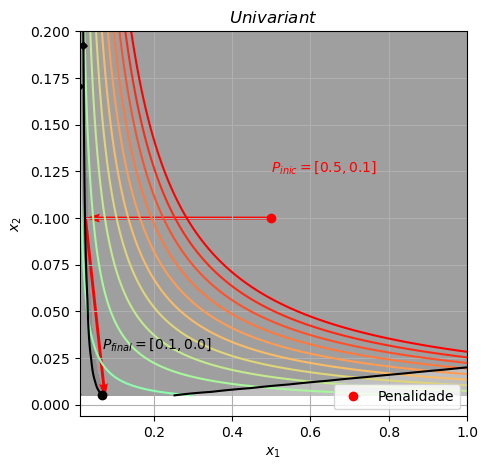

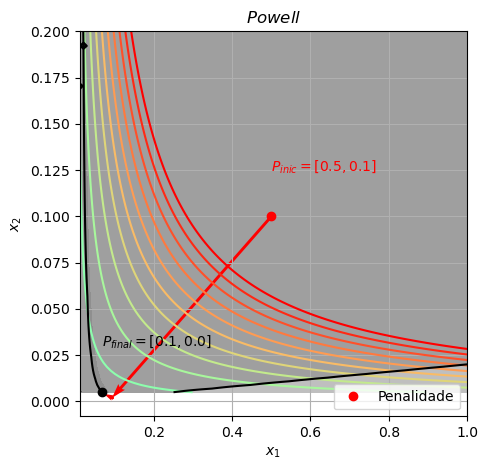

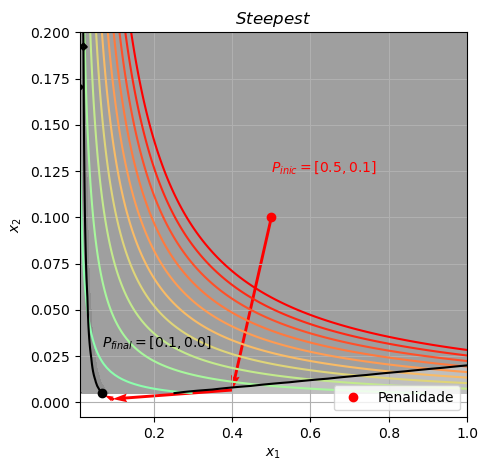

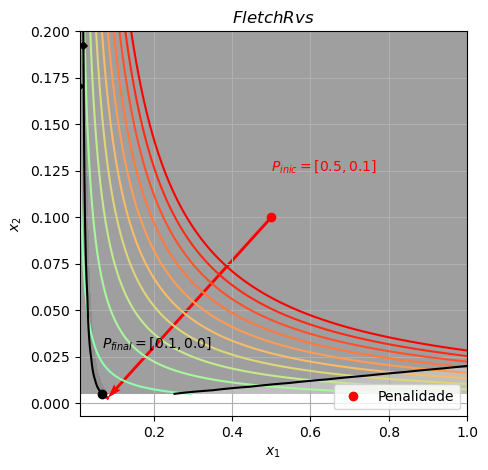

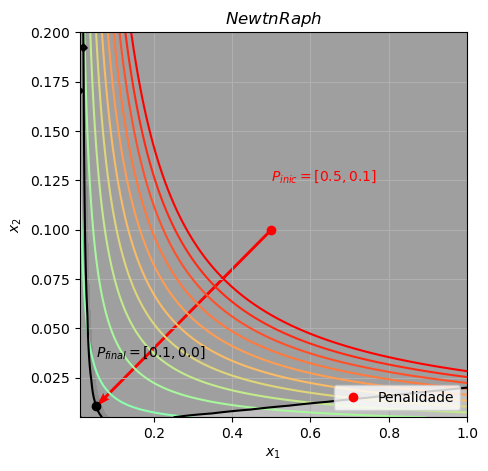

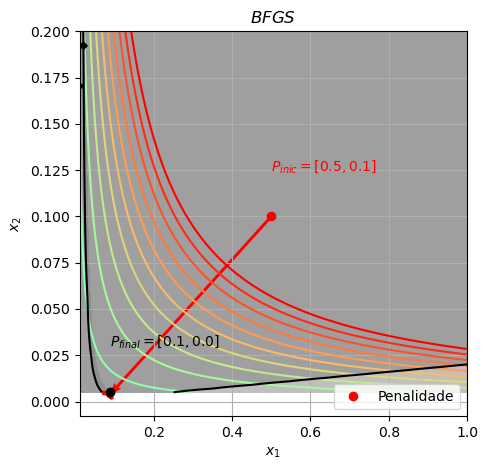

In [13]:
item = '4'

x = np.linspace(0.01, 1.0, 100)
y = np.linspace(0.005, 0.2, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
#levels =[0, 1, 2, 5, 7, 10, 20, 30, 40, 50, 70]
levels = np.linspace(-7000,7000, 20)
cZs = [cf(X, Y) for cf in cfs]

for name, optimizer in optimizrs:
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.contour(X, Y, Z, levels ,cmap='rainbow')
    for cZ in cZs[:-3]:
        ax.contour(X, Y, cZ, [0],cmap='gray')
        ax.contourf(X, Y, cZ, [-100000, 0],cmap='gray', alpha=0.5)
    for case_name, p_inicial, constrs, color, step in cases:
        if case_name == 'Barreira' and name not in []: break
        print(f'Iniciando {name} ({case_name}): p_inicial = [{p_inicial[0]:.6f}, {p_inicial[1]:.6f}].T')
        t_init = datetime.datetime.now()
        f_otim = constraints.ConstrainedSpecialFunction(f, cfuncs=constrs)
        p_final = constrained_optimizer(f_otim, p_inicial, optimizer, step)
        t_final = datetime.datetime.now()
        print(f'{name} ({case_name}): p_final = [{p_final[0]:.6f}, {p_final[1]:.6f}, {f(*p_final):.6f}].T. Execução:{t_final - t_init}, {constrained_optimizer.iter} iterações')
        ax.plot(*p_inicial, f'{color}o',label=case_name)
        ax.text(p_inicial[0]-0.0, p_inicial[1]+0.025, f'$P_{{inic}} = [{p_inicial[0]}, {p_inicial[1]}]$', color=color)
        ax.plot(*p_final, 'ko')
        ax.text(p_final[0]-0.0, p_final[1]+0.025, f'$P_{{final}} = [{p_final[0]:.1f}, {p_final[1]:.1f}]$', color='k')
        cache = constrained_optimizer.cache_x
        for i in range(len(cache)-1):
            p_i = cache[i]
            p_f = cache[i+1]
            ax.quiver(p_i[0], p_i[1], p_f[0]-p_i[0], p_f[1]-p_i[1], color=color, angles='xy', scale_units='xy', scale=1)#, label='Passo completo')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'${name}$')
    fig.savefig(f'images/q{item}_{name}.pdf')